# Call Center Staffing and Scheduling Project

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data">Data Information</a></li>
<li><a href="#workforce">Workforce Management</a></li>
    <li><a href="#erlang">Staffing levels</a></li>
<li><a href="#shift_scheduling">Shift Scheduling</a></li>
<li><a href="#cost">Cost Optimization</a></li>   
</ul>

In [1]:
# This command imports the Gurobi functions and classes.

import gurobipy as gp
from gurobipy import GRB

from pyworkforce.queuing import ErlangC
from pyworkforce.queuing import MultiErlangC

import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re
import itertools
from itertools import repeat
import seaborn as sns

# Introduction
<a id='intro'></a>

Call centers refers to any service provider organization that establish communication between customers and businesses. It constitutes a set of resources (personnnels and telecommunication equipments) which enables delivery of services majorly via the telephone, chat and email.<br>
Unlike many other industries, call center service capacity depends whole on the quantity and skills of human resources available. Report have shown that, personnel cost account for about 60 to 70% of the total operational cost in call centers. Due to this huge dependence, man power planning is an inevitable challenge to overcome for managers. 

### Period-by-period staffing

Finding a suitable fit between the anticipated workload and the planned manpower is crucial. Long wait times and low service levels might result from an undersized workforce. By scheduling a sufficient number of workers, this can be prevented. However, scheduling too many workers is not advisable because call centers must also satisfy financial goals in addition to service levels. As a result, staffing will be done in a period-by-period manner, reason being that, if we consider the peak periods to staff the call center, there is going to be redundant agents at other less peak periods and the manager of the center would be spending more than necessary. <br>

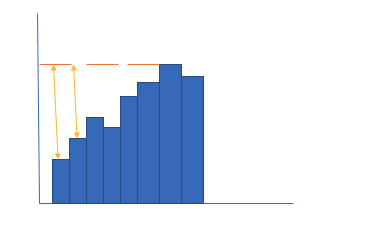

The bar chart above shows a practical scenario of hazard associated with staffing call center agents using peak periods as a reference point. Similar situation will arise even if we pick bar corresponding to mean value, it will either leads to overstaffing and/or understaffing which will in turn affects the overall performance of the center.

# Data Information
<a id='data'></a>
As a test bed, we are going to consider a call center data downloaded from kaggle. The call center opens from 7:45 a.m to 8:00 p.m everyday and the data consists of 1251 time periods of 15 minutes intervals, but for the purpose of this experiment, we are going to consider 49 time periods corresponding to one day with an average handling time of 3 minutes and the following informations presented in the table below;

Table 1

| Shift | Duration | Cost(€)/hour |
| --- | --- | --- |
| 1 | 4 | 72 |
| 2 | 6 | 96 |
| 3 | 8 | 112 |



In [2]:
df = pd.read_csv('Call Center Data.csv')
df

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
0,1,217,204,94.01%,13,0:00:17,0:02:14,0:02:45,76.28%
1,2,200,182,91.00%,18,0:00:20,0:02:22,0:06:55,72.73%
2,3,216,198,91.67%,18,0:00:18,0:02:38,0:03:50,74.30%
3,4,155,145,93.55%,10,0:00:15,0:02:29,0:03:12,79.61%
4,5,37,37,100.00%,0,0:00:03,0:02:06,0:00:35,97.30%
...,...,...,...,...,...,...,...,...,...
1246,1247,191,184,96.34%,7,0:00:07,0:02:50,0:01:56,92.55%
1247,1248,212,209,98.58%,3,0:00:10,0:02:51,0:01:45,89.10%
1248,1249,210,203,96.67%,7,0:00:12,0:03:22,0:03:52,85.24%
1249,1250,167,159,95.21%,8,0:00:16,0:03:16,0:02:42,83.03%


In [3]:
calls = df['Incoming Calls']
volume = calls.iloc[1:50]

In [4]:
%store volume

Stored 'volume' (Series)


In [5]:
resume = "08:00"
close = "20:00"
delta = datetime.timedelta(minutes=15)
start = datetime.datetime.strptime( resume, '%H:%M')
end = datetime.datetime.strptime( close, '%H:%M')
t = start
timeInterval = []
while t <= end:
    timeInterval.append(datetime.datetime.strftime( t, '%H:%M'))
    t += delta

In [6]:
%store timeInterval

Stored 'timeInterval' (list)


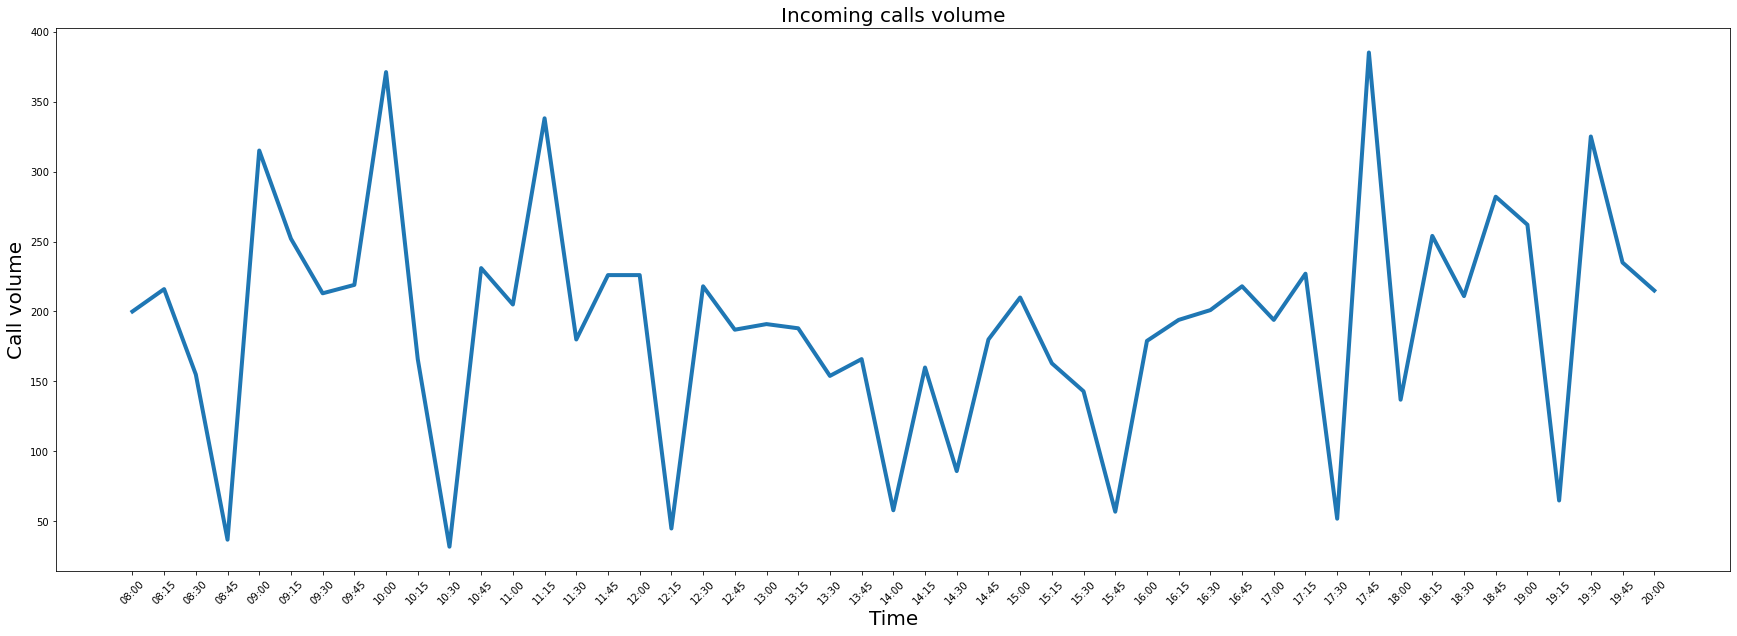

In [7]:
fig = plt.figure()
fig.set_size_inches(30,10)

plt.plot(timeInterval, volume,linewidth = 4)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Call volume', fontsize=20)
#plt.rc('ytick', labelsize=20)
plt.title('Incoming calls volume', fontsize=20)
plt.xticks(rotation=45);

In [8]:
df['Talk Duration (AVG)'] = pd.to_timedelta(df['Talk Duration (AVG)']).astype('timedelta64[s]').astype(int)

df.head()

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
0,1,217,204,94.01%,13,0:00:17,134,0:02:45,76.28%
1,2,200,182,91.00%,18,0:00:20,142,0:06:55,72.73%
2,3,216,198,91.67%,18,0:00:18,158,0:03:50,74.30%
3,4,155,145,93.55%,10,0:00:15,149,0:03:12,79.61%
4,5,37,37,100.00%,0,0:00:03,126,0:00:35,97.30%


In [9]:
df.describe()

,Index,Incoming Calls,Answered Calls,Abandoned Calls,Talk Duration (AVG)
count,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000
mean,626.000000,198.539568,176.845723,21.693845,157.551559
std,361.276902,156.534195,115.612080,59.671955,23.703087
min,1.000000,5.000000,5.000000,0.000000,57.000000
25%,313.500000,123.000000,114.000000,3.000000,142.000000
50%,626.000000,177.000000,166.000000,8.000000,157.000000
75%,938.500000,233.000000,214.500000,16.000000,171.000000
max,1251.000000,1575.000000,909.000000,704.000000,288.000000


# Workforce Management (WFM)
<a id='workforce'></a>
    
WFM is a collection of procedures intended to increase and maintain operational effectiveness by guaranteeing that the appropriate number of agents are staffed at the appropriate time with the right skill sets. WFM is the planning cycle that creates the call center agent schedules. It is usually done a few weeks before the time period (days, weeks, moths or year) for which the schedule is created. The image below shows the steps to be taken in WFM
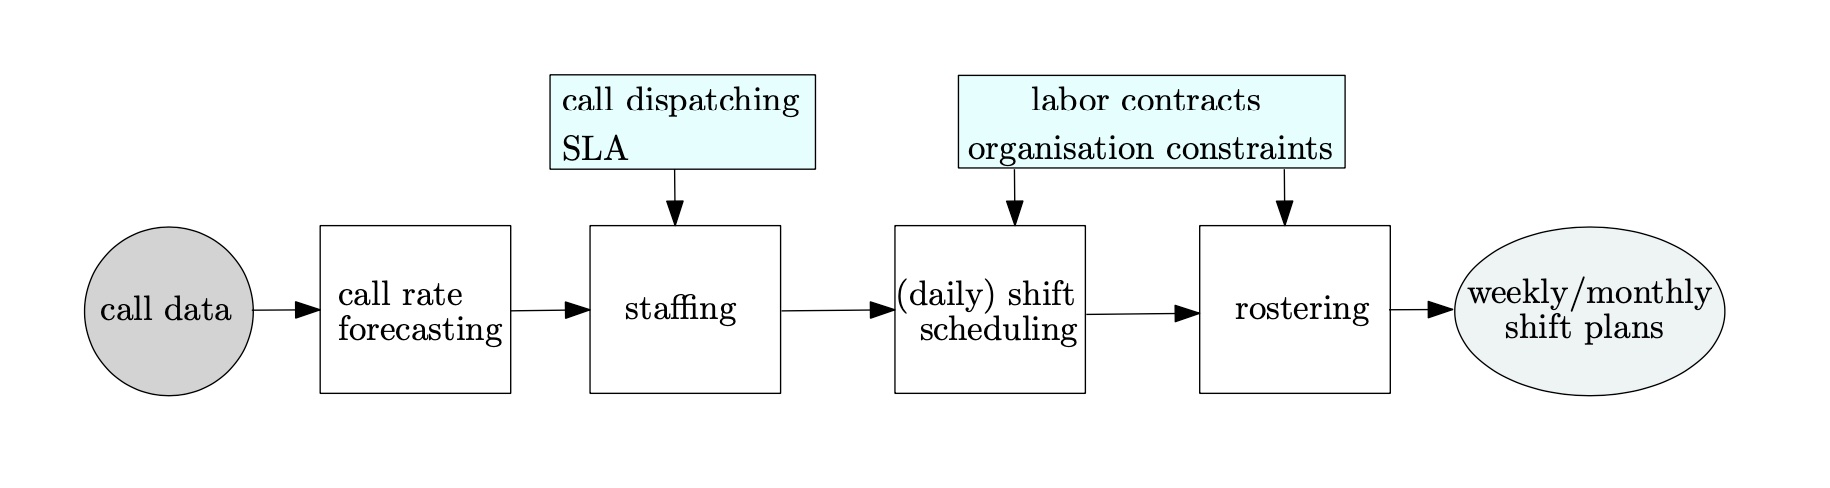


## Erlang C model to compute staffing requirements 
<a id='erlang'></a>

Since call volume data is available, the step to take is to compute the staffing levels. To do this, I will apply Erlang C model with the standard service level agreement (SLA). That is, 80% of calls must be answered within 20seconds. 

In [10]:
#Erlang C model

param_grid = {"transactions": [s for s in volume], "aht": [3], "interval": [15], "asa": [20 / 60]}
multi_erlang = MultiErlangC(param_grid=param_grid, n_jobs=-1)

required_positions_scenarios = {"service_level": [0.8]}

p = multi_erlang.required_positions(required_positions_scenarios)

erl = pd.DataFrame.from_dict(p)
erl.head()

,raw_positions,positions,service_level,occupancy,waiting_probability
0,45,45,0.804519,0.888889,0.340706
1,49,49,0.845355,0.881633,0.294588
2,36,36,0.833087,0.861111,0.290914
3,11,11,0.890235,0.672727,0.163751
4,69,69,0.817663,0.913043,0.355145


In [11]:
staffing_level = [x["positions"] for x in p]
service_level = [x["service_level"] for x in p]

slots = [str("slot{0}".format(i)) for i in range(1,50)]
t = dict(zip(slots,staffing_level))

In [12]:
%store staffing_level
%store slots

Stored 'staffing_level' (list)
Stored 'slots' (list)


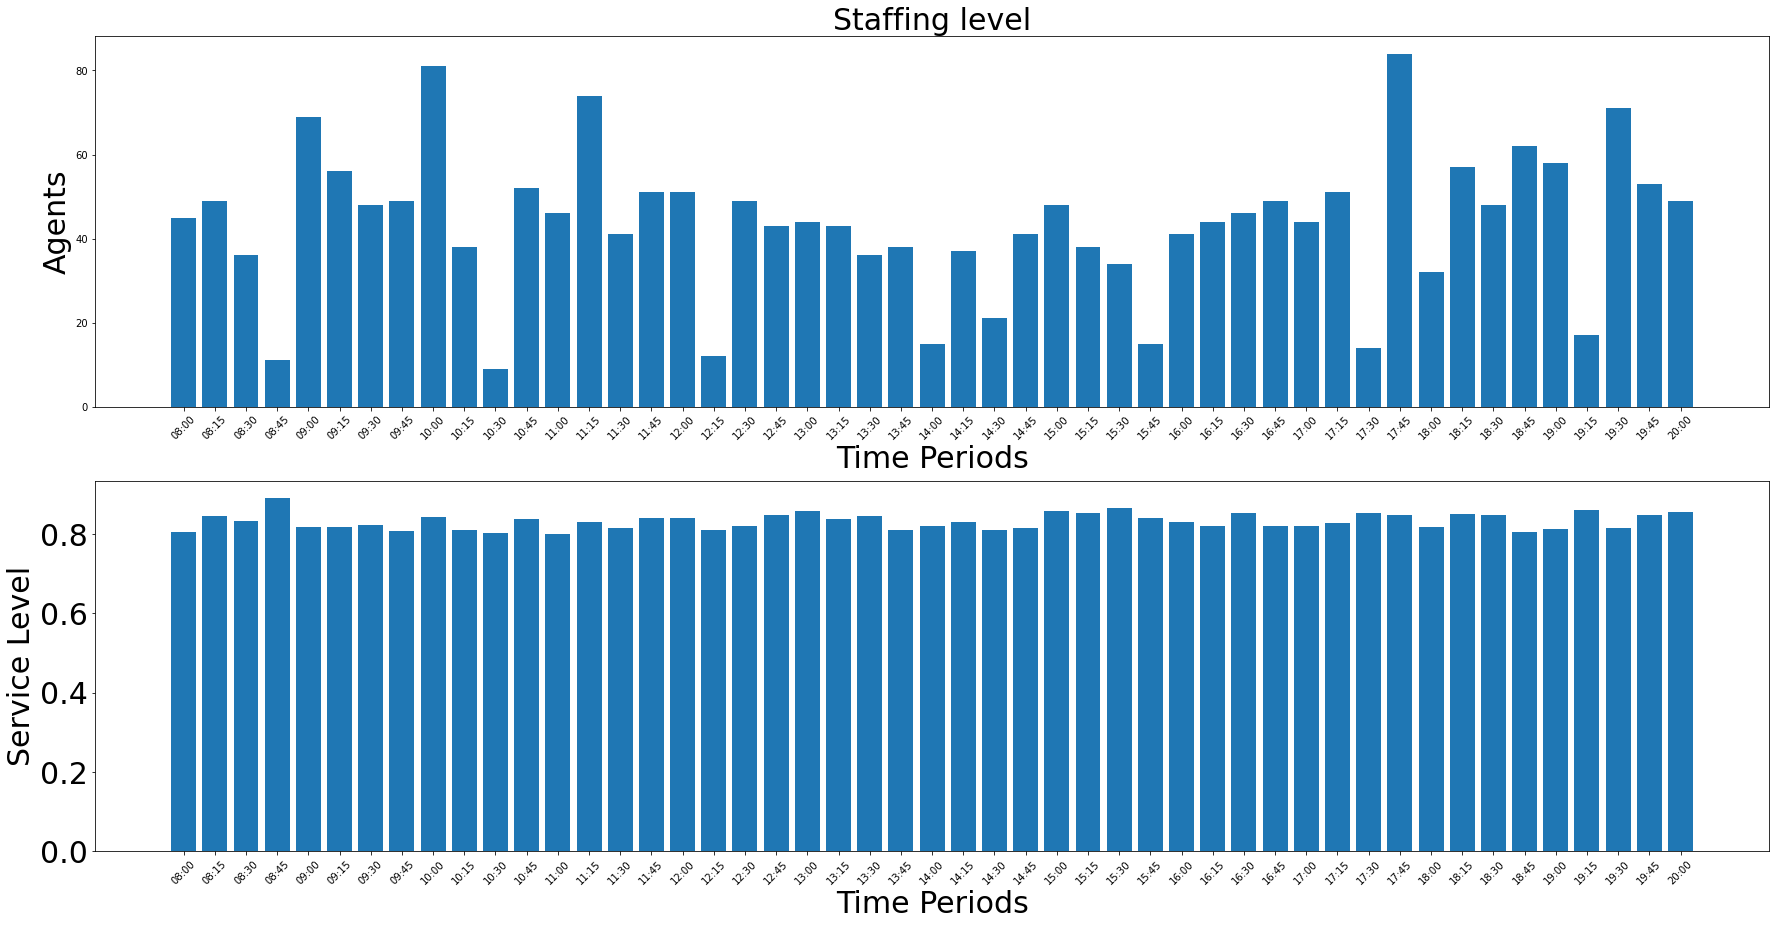

In [13]:
fig = plt.figure()
fig.set_size_inches(30,15)

plt.subplot(2, 1, 1) 
plt.bar(timeInterval, staffing_level,linewidth = 4);
plt.xlabel('Time Periods', fontsize=30)
plt.ylabel('Agents', fontsize=30)
plt.rc('ytick', labelsize=30)
plt.title('Staffing level', fontsize=30)
plt.xticks(rotation=45);


plt.subplot(2, 1, 2) 
plt.bar(timeInterval, service_level)
plt.xlabel('Time Periods', fontsize=30)
plt.ylabel('Service Level', fontsize=30)
plt.rc('ytick', labelsize=30)
plt.xticks(rotation=45);


The bar chart above shows staffing requirement at each period and corresponding service level with respect to the incoming call volumes. Next step is to compute the shift requirement given that three shifts are available. 

## Shift Scheduling 
<a id='shift_scheduling'></a>

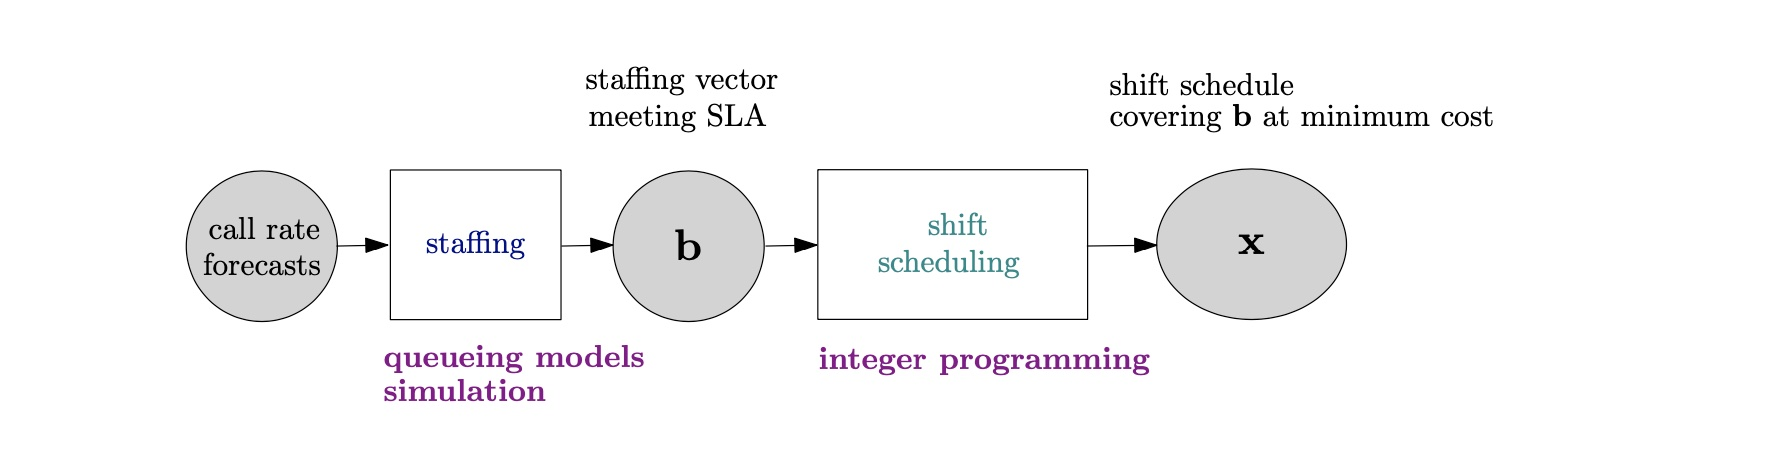
                    \begin{align}
						\textit{Min} \qquad &\sum_{j=1}^{3}c_j x_j \qquad\quad\nonumber\\
						\text{s.t} \qquad &\sum_{j=1}^{3} a_{tj} x_j \ge b_t \nonumber\\
						&t=\{1,2,3,4, \cdots , 49\} \nonumber\\
						&x_j \in Z_{n}^{+}
						\label{agent-schedule model2}
					\end{align} 
where <br>
                    $c_j$ :  Salary of agent assigned to shift $ j $ <br>
					$ x_j$ :  Agents assigned to shift $ j $ <br>
					$ b_t $ :  Staffing level at period $ t $ <br>
                    
   \begin{eqnarray}
		a_{tj}  =  \left\{
		\begin{array}{lr}
            1, \;\;  \text{if shift j covers t}\\
            0, \;\;  otherwise
		\end{array}\right.
	\end{eqnarray}    

Erlang C model from queueing theory has been used to obtained staffing levels (b). This will now be used as an input in the integer programming model above and then solved by Gurobi optimizer. 
- I will now transform the informations in table 1 into gurobi readable format

In [14]:
timeSlots, staffing_levels = gp.multidict(t)
available_shifts, cost = gp.multidict({"shift1": 72, "shift2": 96, "shift3": 112})
available_shifts, duration = gp.multidict({"shift1": 4, "shift2": 6, "shift3": 8})

In [15]:
matr = []
for i in slots:
    for j in available_shifts:
        matr.append((i, j))


In [16]:
slot_shifts = gp.tuplelist(matr)

In [17]:
#create initial model

m = gp.Model("call_center_WFM")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-03


In [18]:
#binary constraint

a_tj = m.addVars(slot_shifts, vtype=GRB.BINARY, name="a_tj")

In [19]:
#available shifts 
actualAgent = m.addVars(available_shifts, vtype=GRB.INTEGER, name='X')

#constraints 1: staffing constraint
shift_reqmts = m.addConstrs((gp.quicksum(a_tj[t,j]*actualAgent[j] for j in available_shifts)
                             >= staffing_levels[t] for t in timeSlots), name = 'staffing_levels')

#constraint 2: Time constraint
Shift_bounds = m.addConstrs((gp.quicksum(a_tj[t,j] for t in timeSlots) 
                                         <= 4*duration[j] for j in available_shifts), 
                                            name = 'Time_bound')

In [20]:
#objective function: to minimize agents' salary

obj = gp.quicksum(actualAgent[j]*cost[j] for j in available_shifts)
m.setObjective(obj , GRB.MINIMIZE)

In [21]:
#set running time to 300secs
m.setParam(GRB.Param.TimeLimit, 300)

#output the problem in gurobi .lp format
m.write('call_center.lp')

#optimize the model
m.optimize()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3 rows, 150 columns and 147 nonzeros
Model fingerprint: 0xb804bdc3
Model has 49 quadratic constraints
Variable types: 0 continuous, 150 integer (147 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [7e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 3e+01]
  QRHS range       [9e+00, 8e+01]
Presolve time: 0.00s
Presolved: 346 rows, 591 columns, 1029 nonzeros
Presolved model has 294 SOS constraint(s)
Variable types: 0 continuous, 591 integer (294 binary)

Root relaxation: objective 6.048000e+03, 316 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 

Shifts Requirement
    Shift  Number of agents
0  shift1              26.0
1  shift2              15.0
2  shift3              51.0


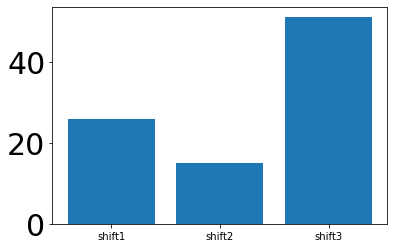

--------------------------------------------------
Shifts distribution
Symbols: '-': not covering, '*': covering
   Time slots shift1 shift2 shift3
0       slot1      -      -      *
1       slot2      -      -      *
2       slot3      -      -      *
3       slot4      -      *      -
4       slot5      *      -      *
5       slot6      -      *      *
6       slot7      -      -      *
7       slot8      -      -      *
8       slot9      *      *      *
9      slot10      *      *      -
10     slot11      -      *      -
11     slot12      -      *      *
12     slot13      -      -      *
13     slot14      *      -      *
14     slot15      -      -      *
15     slot16      -      -      *
16     slot17      -      -      *
17     slot18      -      *      -
18     slot19      -      -      *
19     slot20      -      -      *
20     slot21      -      -      *
21     slot22      -      -      *
22     slot23      *      *      -
23     slot24      *      *      -
24     slot2

In [22]:
solution = {}
shifts_sol = {}
assignments_all = {}
gant={}

assignments = dict()
for [w, s] in list(slot_shifts):
    if a_tj[w, s].x == 1:
        if w in assignments:
            assignments[w].append(s)
        else:
            assignments[w] = [s]

for s in available_shifts:
    shifts_sol[s]=actualAgent[s].X
    
for t in slots:
    assignments_all[t]=assignments.get(t, [])

print('Shifts Requirement')
print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['Shift', 'Number of agents']))


shiftVar = [str("X[shift{0}]".format(i)) for i in range(1,4)]
varInfo = [(v.varName, v.X) for v in m.getVars() if v.X > 0 and v.varname in shiftVar]
val = [a[1] for a in varInfo]

plt.bar(available_shifts[0:], val)
plt.show()


###########################################
print('-'*50)
for w in assignments_all:
    gant[w] = [w]
    for d in available_shifts:
        gant[w].append('*' if d in assignments_all[w] else '-')
        
print('Shifts distribution')
print('Symbols: \'-\': not covering, \'*\': covering')
print(pd.DataFrame.from_records(list(gant.values()), columns=['Time slots']+available_shifts))

#########################
print('-'*50)
print('optimal cost')
print(m.ObjVal)

Having solved the integer programming problem, the number of agents required in each shift and respective time slots to cover has also been determined. It's time to compare this distribution with the one from Erlang C model. 

In [23]:
a_ij = [str("a_tj[slot{0},shift{1}]".format(i,j)) for i in range(1,50) for j in range(1,4)]

aij_Info = [(v.varName, v.X) for v in m.getVars() if v.X > 0 and v.varname in a_ij]

x = [a[0] for a in aij_Info]

Total_staff = list(itertools.repeat(0,49))
staff_sum = 0
for p in range(1,50):
    for q in range(1,4):
        if str("a_tj[slot{0},shift{1}]".format(p,q)) in x:
           Total_staff[p-1] += int(val[q-1])   

In [24]:
%store Total_staff

Stored 'Total_staff' (list)


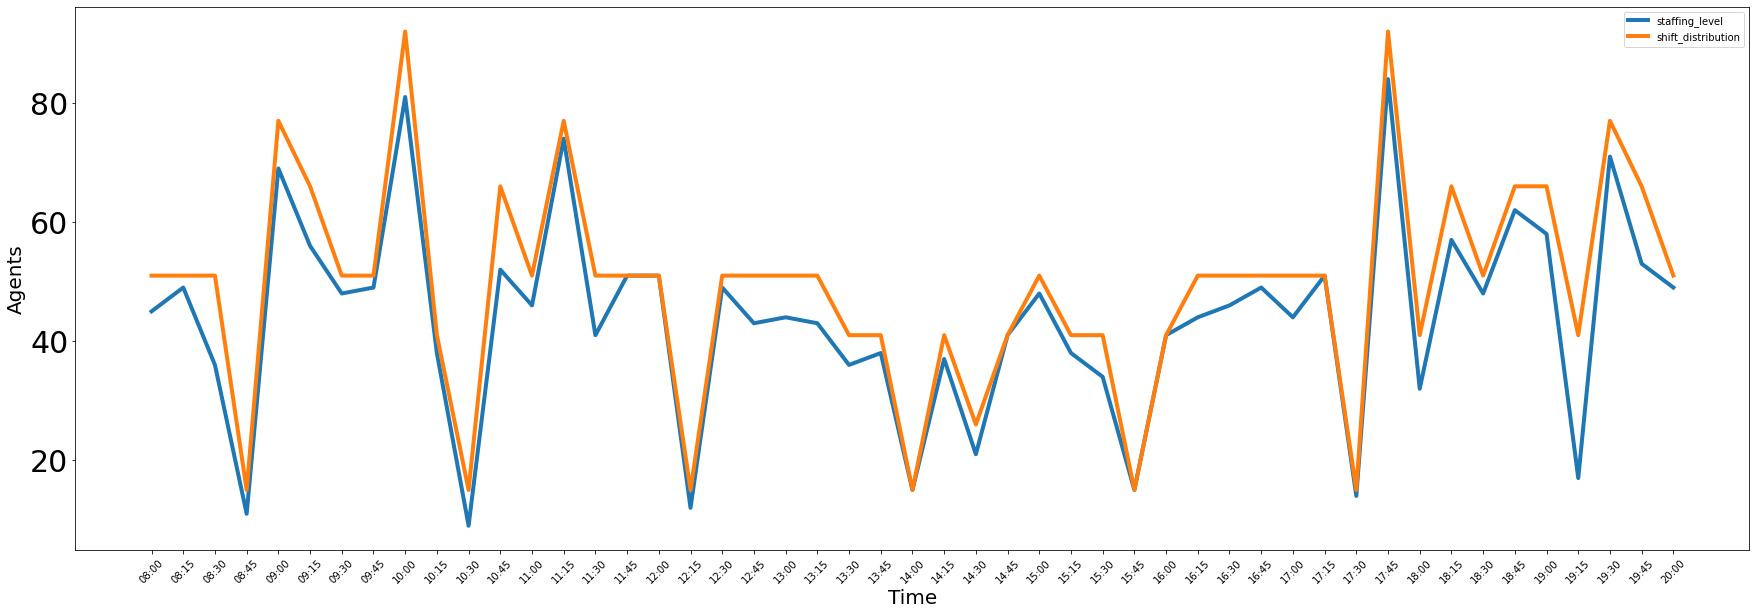

In [25]:
fig = plt.figure()
fig.set_size_inches(30,10)

plt.plot(timeInterval, staffing_level,linewidth = 4, label='staffing_level');
plt.plot(timeInterval, Total_staff,linewidth = 4, label='shift_distribution');

plt.xlabel('Time', fontsize=20)
plt.ylabel('Agents', fontsize=20)
plt.rc('ytick', labelsize=20)
plt.xticks(rotation=45);
plt.legend();

Figure above compares Gurobi shift distribution and initial staffing levels, it is worth noticing that the orange line (shift distribution) is above the blue line (staffing level determined by Erlang model) at many periods. This gives a clear information indicating that we have overstaffed the call center. The most possible explanation to this could be due to the constrictive nature of service level and relative rigidity of shifts, the obligation to satisfy service requirements in each interval frequently results in significant overstaffing.

Mean of achieved service level
0.951287988658519


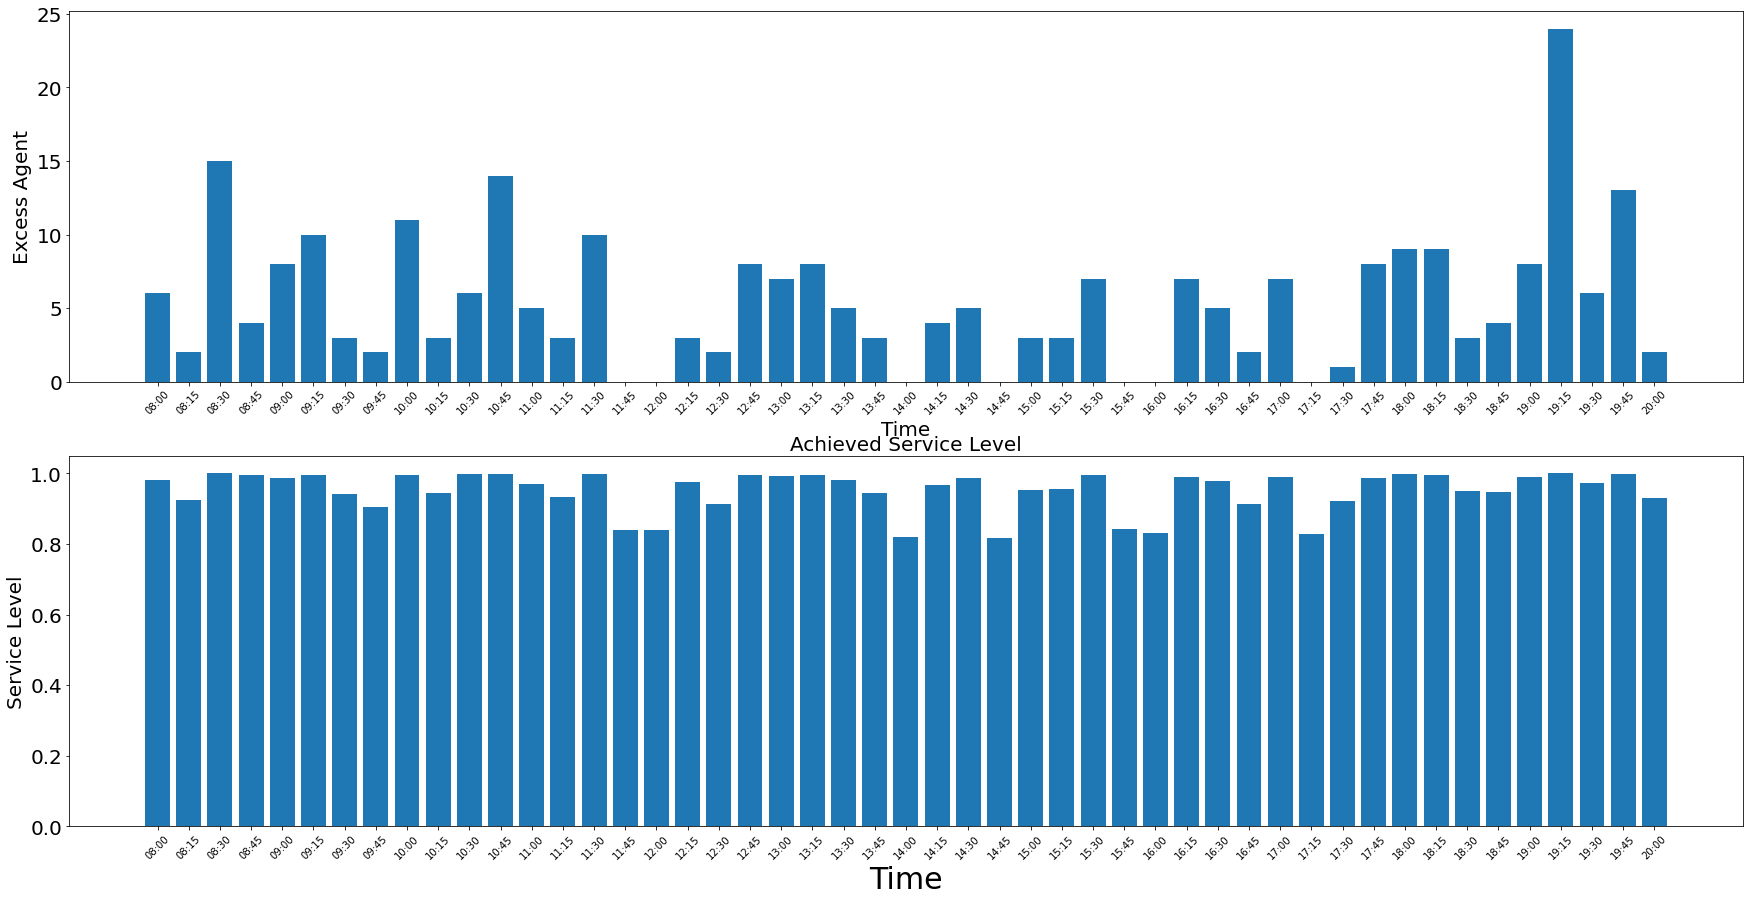

In [26]:
diff = np.array(Total_staff) - np.array(staffing_level)

new_SL =[]
for i in range(1,50):
    erlang = ErlangC(transactions=volume[i], aht=3, interval=15, asa=20/60)
    achieved_service_level = erlang.service_level(positions=Total_staff[i-1])
    new_SL.append(achieved_service_level)

print('Mean of achieved service level')
print(mean(new_SL))


fig = plt.figure()
fig.set_size_inches(30,15)

plt.subplot(2, 1, 1) 
plt.bar(timeInterval, diff.tolist())
plt.xlabel('Time', fontsize=20)
plt.ylabel('Excess Agent', fontsize=20)
plt.xticks(rotation=45);


plt.subplot(2, 1, 2) 
plt.bar(timeInterval, new_SL)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Service Level', fontsize=20)
plt.rc('ytick', labelsize=20)
plt.title('Achieved Service Level', fontsize=20)
plt.xticks(rotation=45);


 The first bar chart above shows excess number of agents scheduled at each period indicating up to about 24 excess schedule while the second bar chart shows the achieved service levels having mean of 95% which is 15% more than required. 

# Cost Optimization
<a id='cost'></a>

We have seen that leaving to Integer Programming the role of covering at minimim cost the staffing requirements is really not the best. It often lead to overstaffing of call center. <br>
In order to handle this, minimum cost can be obtained by the following approaches; 
- adjust the service level agreement and/or average speed of answer,
- strike a balance between scheduling too much or less by solving flexible integer programming model. 